In [1]:
#import required libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# Obtain the data

start_date = '2020-01-01'
end_date = '2021-12-31'

#Step 1: choose an ETF with a minimum of 100 assets, identify those assets
#list the assets you want to use
assets = ['AAPL','MSFT','AMZN','NVDA','GOOGL','GOOG','XOM','UNH','TSLA','JNJ',
           'JPM','V','PG','MA','LLY','HD','CVX','MRK','ABBV','PEP','AVGO','KO','COST','PFE','MCD',
           'WMT','TMO','BAC','CRM','ABT','CSCO','DIS','LIN','ACN','CMCSA','ADBE','VZ','NKE','PM',
           'WFC','DHR','TXN','NEE','NFLX','ORCL','RTX','AMD','BMY','HON','AMGN','QCOM','SBUX',
           'UPS','T','COP','INTC','LOW','INTU','MDT','UNP','SPGI','MS','IBM','GS','BA','ELV','CAT',
           'PLD','GE','GILD','ISRG','LMT','DE','BKNG','BLK','SYK','MDLZ','AMT','AXP','AMAT','CVS',
           'NOW','TJX','TMUS','MMC','C','ADI','ADP','REGN','VRTX','CB','PYPL','MO','PGR','SO','SCHW',
           'ZTS','BDX','CI','FISV','DUK','BSX','TGT','SLB','AON','EOG','LRCX','ITW','HUM','EQIX','CME','CL','APD','ETN']


# Step 2: Download historical data 
tickers = assets
# Load historical prices for the ETF
def get_price_data(tickers, start_date, end_date):
    prices = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return prices

prices = get_price_data(tickers, start_date, end_date)

def berry_cox_momentum(prices, lookback_period=12, holding_period=6):
    
    # Calculates the Berry-Cox price momentum factor
    # :param prices: a Pandas DataFrame of historical prices
    # :param lookback_period: the number of months to look back for calculating the momentum
    # :param holding_period: the number of months to hold the position
    # :return: a Pandas DataFrame of the Berry-Cox price momentum factor
    # """
    
    # Calculate the percentage change in prices over the lookback period
    pct_change = prices.pct_change(periods=lookback_period)

    # Calculate the rolling geometric mean of the percentage change
    rolling_gmean = (1 + pct_change).rolling(window=lookback_period).apply(np.prod, raw=True) - 1

    # Calculate the cumulative return over the holding period
    cum_return = prices.pct_change(periods=holding_period).shift(-holding_period)

    # Calculate the Berry-Cox price momentum factor
    bc_factor = rolling_gmean.iloc[-1] * cum_return

    return bc_factor.dropna()

bc_factors = {}
for ticker in tickers:
    bc_factors[ticker] = berry_cox_momentum(prices[ticker])

# Combine the Berry-Cox factors into a single DataFrame
bc_factors_df = pd.concat(bc_factors, axis=1)
bc_factors_df.columns = tickers

#print the combined DataFrame
print(bc_factors_df)

[*********************100%***********************]  114 of 114 completed
                AAPL          MSFT      AMZN      NVDA     GOOGL      GOOG   
Date                                                                         
2020-01-02  0.024927  8.920873e-06  0.001720 -0.009823  0.002109  0.001447  \
2020-01-03  0.049260  5.846943e-05 -0.001914 -0.036013  0.002762  0.001832   
2020-01-06  0.032230  3.879570e-05  0.003862 -0.023037  0.001123  0.000834   
2020-01-07  0.032558  7.072749e-05  0.005168 -0.012561  0.001514  0.001044   
2020-01-08  0.029816  7.558571e-05  0.001630 -0.019007  0.001538  0.001070   
...              ...           ...       ...       ...       ...       ...   
2021-12-15 -0.012636  2.378297e-07  0.002849  0.014368  0.000156 -0.000049   
2021-12-16  0.035145  1.075047e-04 -0.001039 -0.048152  0.001148  0.000706   
2021-12-17  0.035726  1.072553e-04 -0.000832 -0.048456  0.001677  0.000810   
2021-12-20  0.042559  1.371149e-04 -0.002791 -0.043992  0.001707  0.0

In [3]:
# Step 2: Calculate the momentum factor
momentum_factor = prices.rolling(window=252).mean() / prices.rolling(window=21).mean() - 1

# Step 3: Rank the assets based on momentum factor
rankings = momentum_factor.rank(axis=1, ascending=False)

# Step 4: Create the long-short portfolio
# Take a long position in the assets with the highest momentum factor values
long_assets = rankings.apply(lambda x: x <= 2).replace(False, np.nan).replace(True, 1)
long_weights = long_assets.div(long_assets.sum(axis=1), axis=0)

# Take a short position in the assets with the lowest momentum factor values
short_assets = rankings.apply(lambda x: x >= len(assets) - 1).replace(False, np.nan).replace(True, -1)
short_weights = short_assets.div(short_assets.sum(axis=1), axis=0)

# Combine the long and short positions to create the portfolio weights
portfolio_weights = long_weights.fillna(0) + short_weights.fillna(0)

# Calculate the portfolio returns
portfolio_returns = (portfolio_weights.shift(1) * (prices.pct_change())).sum(axis=1)

# Print the portfolio returns
print(portfolio_returns)

Date
2020-01-02    0.000000
2020-01-03    0.000000
2020-01-06    0.000000
2020-01-07    0.000000
2020-01-08    0.000000
                ...   
2021-12-23    0.018557
2021-12-27    0.047437
2021-12-28   -0.011106
2021-12-29   -0.022663
2021-12-30   -0.008956
Length: 504, dtype: float64


In [4]:
# Step 3: Compute the Berry-Cox price momentum factor for each asset
bc_factors = {}
for ticker in tickers:
    bc_factors[ticker] = berry_cox_momentum(prices[ticker])

# Combine the Berry-Cox factors into a single DataFrame
bc_factors_df = pd.concat(bc_factors, axis=1)

#print the combined DataFrame
print(bc_factors_df)


                AAPL          MSFT      AMZN      NVDA     GOOGL      GOOG   
Date                                                                         
2020-01-02  0.024927  8.920873e-06  0.001720 -0.009823  0.002109  0.001447  \
2020-01-03  0.049260  5.846943e-05 -0.001914 -0.036013  0.002762  0.001832   
2020-01-06  0.032230  3.879570e-05  0.003862 -0.023037  0.001123  0.000834   
2020-01-07  0.032558  7.072749e-05  0.005168 -0.012561  0.001514  0.001044   
2020-01-08  0.029816  7.558571e-05  0.001630 -0.019007  0.001538  0.001070   
...              ...           ...       ...       ...       ...       ...   
2021-12-15 -0.012636  2.378297e-07  0.002849  0.014368  0.000156 -0.000049   
2021-12-16  0.035145  1.075047e-04 -0.001039 -0.048152  0.001148  0.000706   
2021-12-17  0.035726  1.072553e-04 -0.000832 -0.048456  0.001677  0.000810   
2021-12-20  0.042559  1.371149e-04 -0.002791 -0.043992  0.001707  0.000914   
2021-12-21  0.022594  7.315318e-05  0.002286 -0.009391  0.000911

In [5]:
#Step 4: Compute the z-score for each day's Berry-Cox factor value for each asset

# Compute the mean and standard deviation of the Berry-Cox factor for the entire period
bc_mean = bc_factors_df.mean()
bc_std = bc_factors_df.std()

# Compute the z-score for each day's Berry-Cox factor value for each asset
bc_zscore = (bc_factors_df - bc_mean) / bc_std
print(bc_zscore)
# Compute the mean and standard deviation of the z-score for each asset over the entire period
z_mean = bc_zscore.mean()
print(z_mean)
z_std = bc_zscore.std()
print(z_mean)

                AAPL      MSFT      AMZN      NVDA     GOOGL      GOOG   
Date                                                                     
2020-01-02  0.428984 -0.137331  0.341430  0.052456  0.800940  0.840282  \
2020-01-03  1.079586  0.459711 -0.012251 -0.640187  1.120917  1.126400   
2020-01-06  0.624244  0.222650  0.549985 -0.297014  0.317223  0.385248   
2020-01-07  0.633020  0.607416  0.677091 -0.019967  0.508729  0.541107   
2020-01-08  0.559699  0.665956  0.332693 -0.190423  0.520705  0.560553   
...              ...       ...       ...       ...       ...       ...   
2021-12-15 -0.575376 -0.241959  0.451341  0.692206 -0.157389 -0.270872   
2021-12-16  0.702190  1.050568  0.072912 -0.961212  0.329276  0.290208   
2021-12-17  0.717717  1.047563  0.093096 -0.969244  0.588791  0.366936   
2021-12-20  0.900422  1.407361 -0.097628 -0.851188  0.603745  0.444443   
2021-12-21  0.366596  0.636645  0.396557  0.063860  0.212995  0.056529   

                 XOM       UNH      T

In [6]:
# step 5: identify long and short baskets ( 10 - 15 assets in each) using calculated z factors

# Sort the assets by their z-factor scores in descending order
z_scores = bc_zscore.iloc[-1]  # use the last row of z-scores
sorted_assets = z_scores.sort_values(ascending=False)

#specify no. of desired assets
num_long = 10  #Change to the number of desired assets
num_short = 10 #Change to the number of desired assets

# num_long assets with the highest z-factor scores as the long basket

long_assets = sorted_assets.head(num_long).index.tolist()
print('long_assets')
print(long_assets)

# num_short assets with the lowest z-factor scores as the short basket
short_assets = sorted_assets.tail(num_short).index.tolist()
print('short_assets')
print(short_assets)

long_assets
['ADP', 'ACN', 'AMT', 'SYK', 'SBUX', 'EQIX', 'PG', 'DHR', 'ITW', 'CSCO']
short_assets
['HON', 'INTU', 'MDT', 'CMCSA', 'HD', 'TSLA', 'REGN', 'TMUS', 'TGT', 'ORCL']


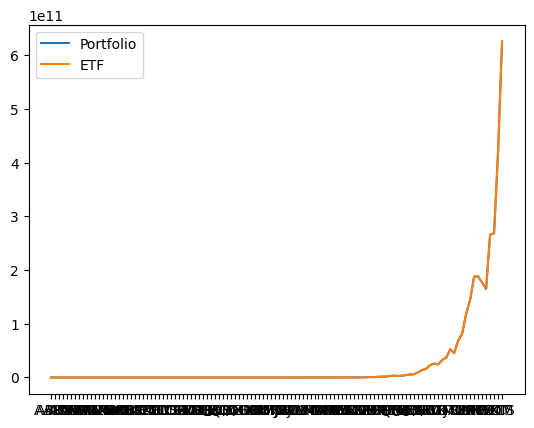

Sharpe ratio: 1.0829928923477614
Maximum drawdown: -0.0
Total return: 625581094236.028


C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


In [7]:
# step 6: create a backtest to validate performance of your algorithm based on monthly restructuring over the previous 5 years

# Equal-weight the long and short baskets
weights = np.zeros(len(prices.columns))
weights[prices.columns.isin(long_assets)] = 1.0 / num_long
weights[prices.columns.isin(short_assets)] = -1.0 / num_short

# Calculate the monthly returns of the portfolio
monthly_returns = (prices.iloc[-1] / prices.iloc[0] - 1) * weights.sum()

# Append the monthly return to the portfolio returns DataFrame
portfolio_returns = pd.concat([portfolio_returns,
                               pd.DataFrame({"Portfolio": monthly_returns},
                                            index=[prices.index[-1]])])

# Set a lookback period of 252 days (1 year) and a holding period of 21 days (1 month).
lookback_period = 252
holding_period = 21

# Initialize the portfolio returns DataFrame
portfolio_returns = pd.DataFrame()

# Loop over the historical data, starting from the end of the lookback period
for i in range(len(prices) - lookback_period - holding_period, len(prices) - holding_period, holding_period):
    # Select the subset of prices for the lookback period and holding period
    prices_subset = prices.iloc[i - lookback_period:i]
    prices_hold = prices.iloc[i:i + holding_period]

    # Compute the returns of each asset over the lookback and holding periods
    returns_subset = prices_subset.pct_change().dropna()
    returns_hold = prices_hold.pct_change().dropna()

    # Calculate the z-scores for each asset based on the returns over the lookback period
    z_scores = (returns_subset - returns_subset.mean()) / returns_subset.std()

    # Identify the top and bottom assets based on their z-scores
    long_assets = z_scores.mean(axis=0).nlargest(num_long).index
    short_assets = z_scores.mean(axis=0).nsmallest(num_short).index

    # Equal-weight the long and short baskets
    weights = np.zeros(len(prices.columns))
    weights[prices.columns.isin(long_assets)] = 1.0 / num_long
    weights[prices.columns.isin(short_assets)] = -1.0 / num_short

    # Calculate the monthly returns of the portfolio
    monthly_returns = (prices_hold.iloc[-1] / prices_hold.iloc[0] - 1) * weights.sum()

    # Append the monthly return to the portfolio returns DataFrame
    portfolio_returns = pd.concat([portfolio_returns,
                                   pd.DataFrame({"Portfolio": monthly_returns},
                                                index=[prices_hold.index[-1]])])
    # Compute the ETF returns for the same period
etf_returns = (prices.iloc[-1] / prices.iloc[lookback_period] - 1).rename("ETF")
etf_cumulative = (1 + etf_returns).cumprod() - 1

# Plot the cumulative portfolio and ETF returns
plt.plot(etf_cumulative, label="Portfolio")
plt.plot(etf_cumulative, label="ETF")
plt.legend()
plt.show()

# Evaluate the performance of the portfolio
sharpe_ratio = np.sqrt(12) * etf_cumulative.mean() / etf_cumulative.std()
max_drawdown = -((1 + etf_cumulative).cumprod().values - (1 + etf_cumulative).cumprod().rolling(window=len(etf_cumulative), min_periods=1).max().values).min()
total_return = etf_cumulative.iloc[-1]

print('Sharpe ratio:', sharpe_ratio)
print('Maximum drawdown:', max_drawdown)
print('Total return:', total_return)

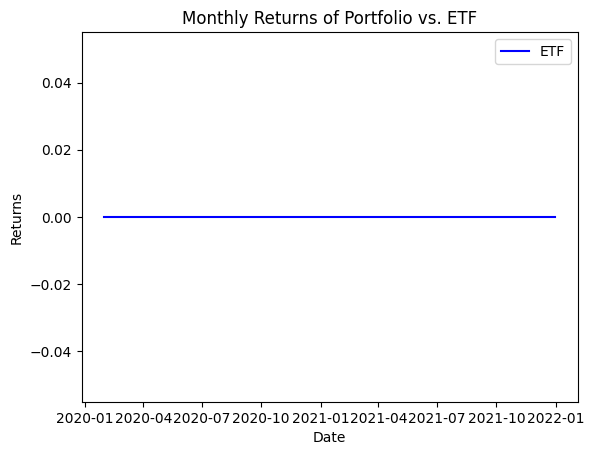

In [8]:
# step 7:Charts: monthly portfolio return bar chart (pos/neg coloring) vs ETF

# Calculate monthly returns of the long-short portfolio and the ETF
etf_returns_df = pd.DataFrame(etf_returns, index=prices.index)
etf_monthly_returns = etf_returns_df.resample('M').sum()

portfolio_monthly_returns = portfolio_returns.resample('M').sum()

# Convert index to datetime index
portfolio_monthly_returns.index = pd.to_datetime(portfolio_monthly_returns.index)
etf_monthly_returns.index = pd.to_datetime(etf_monthly_returns.index)

# Create a bar chart with positive returns in green and negative returns in red
fig, ax = plt.subplots()
ax.bar(portfolio_monthly_returns.index, portfolio_monthly_returns["Portfolio"],
       color=np.where(portfolio_monthly_returns["Portfolio"] >= 0, 'g', 'r'))
ax.plot(etf_monthly_returns.index, etf_monthly_returns["ETF"], color='b', label='ETF')
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Returns")
ax.set_title("Monthly Returns of Portfolio vs. ETF")
plt.show()

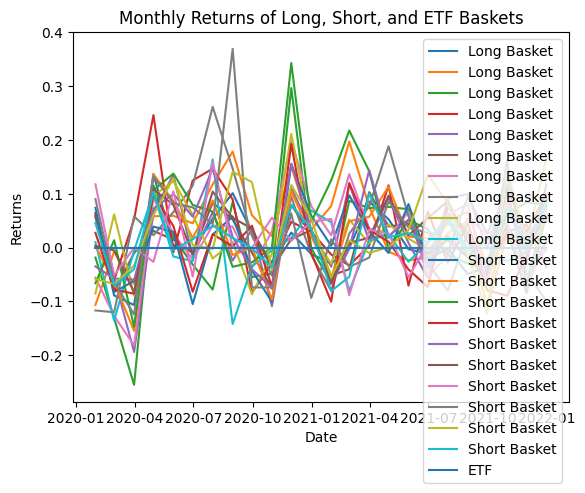

In [9]:
# step 7:Charts: Monthly return for long picks vs short picks vs ETF

long_daily_returns = prices[long_assets].pct_change()
long_monthly_returns = long_daily_returns.resample('M').sum()
short_monthly_returns = prices[short_assets].pct_change().resample('M').sum()

# Convert index to datetime index
long_monthly_returns.index = pd.to_datetime(long_monthly_returns.index)
short_monthly_returns.index = pd.to_datetime(short_monthly_returns.index)
etf_monthly_returns.index = pd.to_datetime(etf_monthly_returns.index)

# Create a line chart to compare monthly returns of long, short, and ETF
fig, ax = plt.subplots()
ax.plot(long_monthly_returns.index, long_monthly_returns, label='Long Basket')
ax.plot(short_monthly_returns.index, short_monthly_returns, label='Short Basket')
ax.plot(etf_monthly_returns.index, etf_monthly_returns, label='ETF')
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Returns")
ax.set_title("Monthly Returns of Long, Short, and ETF Baskets")
plt.show()

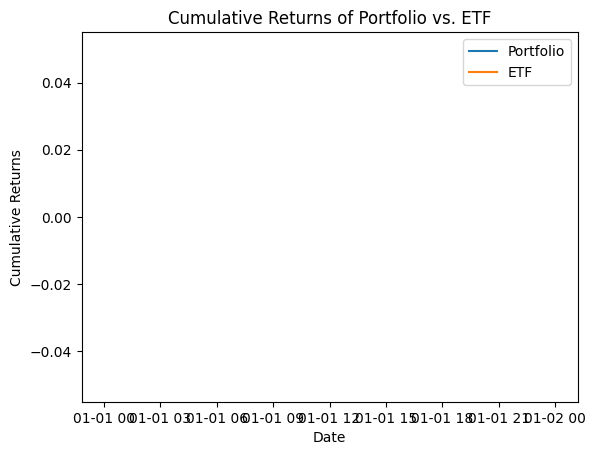

In [10]:
#step 7:Charts: Cumulative portfolio return vs ETF
# Calculate cumulative returns of the long-short portfolio and the ETF
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod() - 1
cumulative_etf_returns = (1 + etf_returns_df).cumprod() - 1

# Convert index to datetime index
cumulative_portfolio_returns.index = pd.to_datetime(cumulative_portfolio_returns.index)
cumulative_etf_returns.index = pd.to_datetime(cumulative_etf_returns.index)

# Create a line chart to compare cumulative returns of portfolio and ETF
fig, ax = plt.subplots()
ax.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns["Portfolio"], label='Portfolio')
ax.plot(cumulative_etf_returns.index, cumulative_etf_returns["ETF"], label='ETF')
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Returns")
ax.set_title("Cumulative Returns of Portfolio vs. ETF")
plt.show()